# 04 - Regression Analysis

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm

import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
import sys
sys.path.append('../')
sys.path.append('../../kungfu/')
import kungfu as kf

C:\ProgramData\Anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Settings

In [4]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [5]:
#sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [6]:
#plt.style.use('fivethirtyeight')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [17, 8]
#plt.rcParams['figure.dpi'] = 80

## Load & prepare data
#### Previously saved

In [7]:
df_crsp_desc = pd.read_pickle('../data/raw/df_crsp_desc.pkl')

In [8]:
df_ff_raw = pd.read_pickle('../data/raw/df_ff_raw.pkl')
df_ff_raw['date'] = pd.to_datetime(df_ff_raw['date'], yearfirst=True)
df_ff_raw = df_ff_raw.set_index('date')

In [9]:
df_estimates = pd.read_pickle('../data/processed/df_estimates.pkl')
df_analysis = pd.read_pickle('../data/processed/df_analysis.pkl')

In [10]:
df_indices = pd.read_pickle('../data/processed/df_indices.pkl')

### Merge data & Explore

In [11]:
df_merged = kf.FinancialDataFrame(df_estimates.merge(df_analysis, how='outer', left_index=True, right_index=True, suffixes=('_est','_ana')))

In [12]:
df_merged['in_lagged'] = df_merged['in'].groupby(df_merged.index.get_level_values(1)).shift(1)
df_merged['in_pct'] = df_merged['in']/df_merged['vola_est']
df_merged['sqrt_in'] = np.sqrt(df_merged['in'])

In [13]:
df_merged.describe()

,in,out,capm_alpha_est,capm_mktrf_est,ff3f_alpha_est,ff3f_mktrf_est,ff3f_smb_est,ff3f_hml_est,c4f_alpha_est,c4f_mktrf_est,...,ret3M_ana,ret12M_ana,ret_ana,vola1M_ana,vola3M_ana,vola12M_ana,vola_ana,in_lagged,in_pct,sqrt_in
count,1900.0000,1900.0000,1900.0000,1900.0000,1900.0000,1900.0000,1900.0000,1900.0000,1900.0000,1900.0000,...,1896.0000,1896.0000,1896.0000,1896.0000,1896.0000,1896.0000,1896.0000,1881.0000,1900.0000,1900.0000
mean,0.0050,0.0050,0.0003,0.9737,0.0003,1.0048,-0.1737,-0.0036,0.0003,1.0076,...,0.0110,0.0834,0.0834,0.0182,0.0175,0.0181,0.0181,0.0051,0.2235,0.0605
std,0.0068,0.0053,0.0009,0.4127,0.0009,0.3358,0.3094,0.7337,0.0009,0.2953,...,0.1338,0.2875,0.2875,0.0123,0.0115,0.0123,0.0123,0.0069,0.1904,0.0371
min,0.0000,0.0001,-0.0047,-0.1588,-0.0033,-0.0147,-2.4796,-2.6741,-0.0034,0.0513,...,-0.6989,-1.0000,-1.0000,0.0011,0.0015,0.0015,0.0015,0.0000,0.0069,0.0063
25%,0.0012,0.0014,-0.0002,0.7197,-0.0002,0.7749,-0.3604,-0.3927,-0.0002,0.8073,...,-0.0588,-0.0701,-0.0701,0.0111,0.0112,0.0117,0.0117,0.0012,0.0862,0.0345
50%,0.0027,0.0029,0.0003,0.9458,0.0003,0.9955,-0.1836,-0.0626,0.0003,1.0033,...,0.0133,0.0893,0.0893,0.0151,0.0147,0.0150,0.0150,0.0027,0.1692,0.0515
75%,0.0058,0.0065,0.0008,1.1952,0.0007,1.2156,-0.0055,0.3468,0.0007,1.1941,...,0.0885,0.2428,0.2428,0.0214,0.0199,0.0202,0.0202,0.0058,0.2929,0.0763
max,0.0560,0.0253,0.0074,3.0914,0.0097,2.3580,1.2087,4.5024,0.0096,2.3399,...,0.8183,1.6232,1.6232,0.1503,0.1503,0.1868,0.1868,0.0560,1.2670,0.2366


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


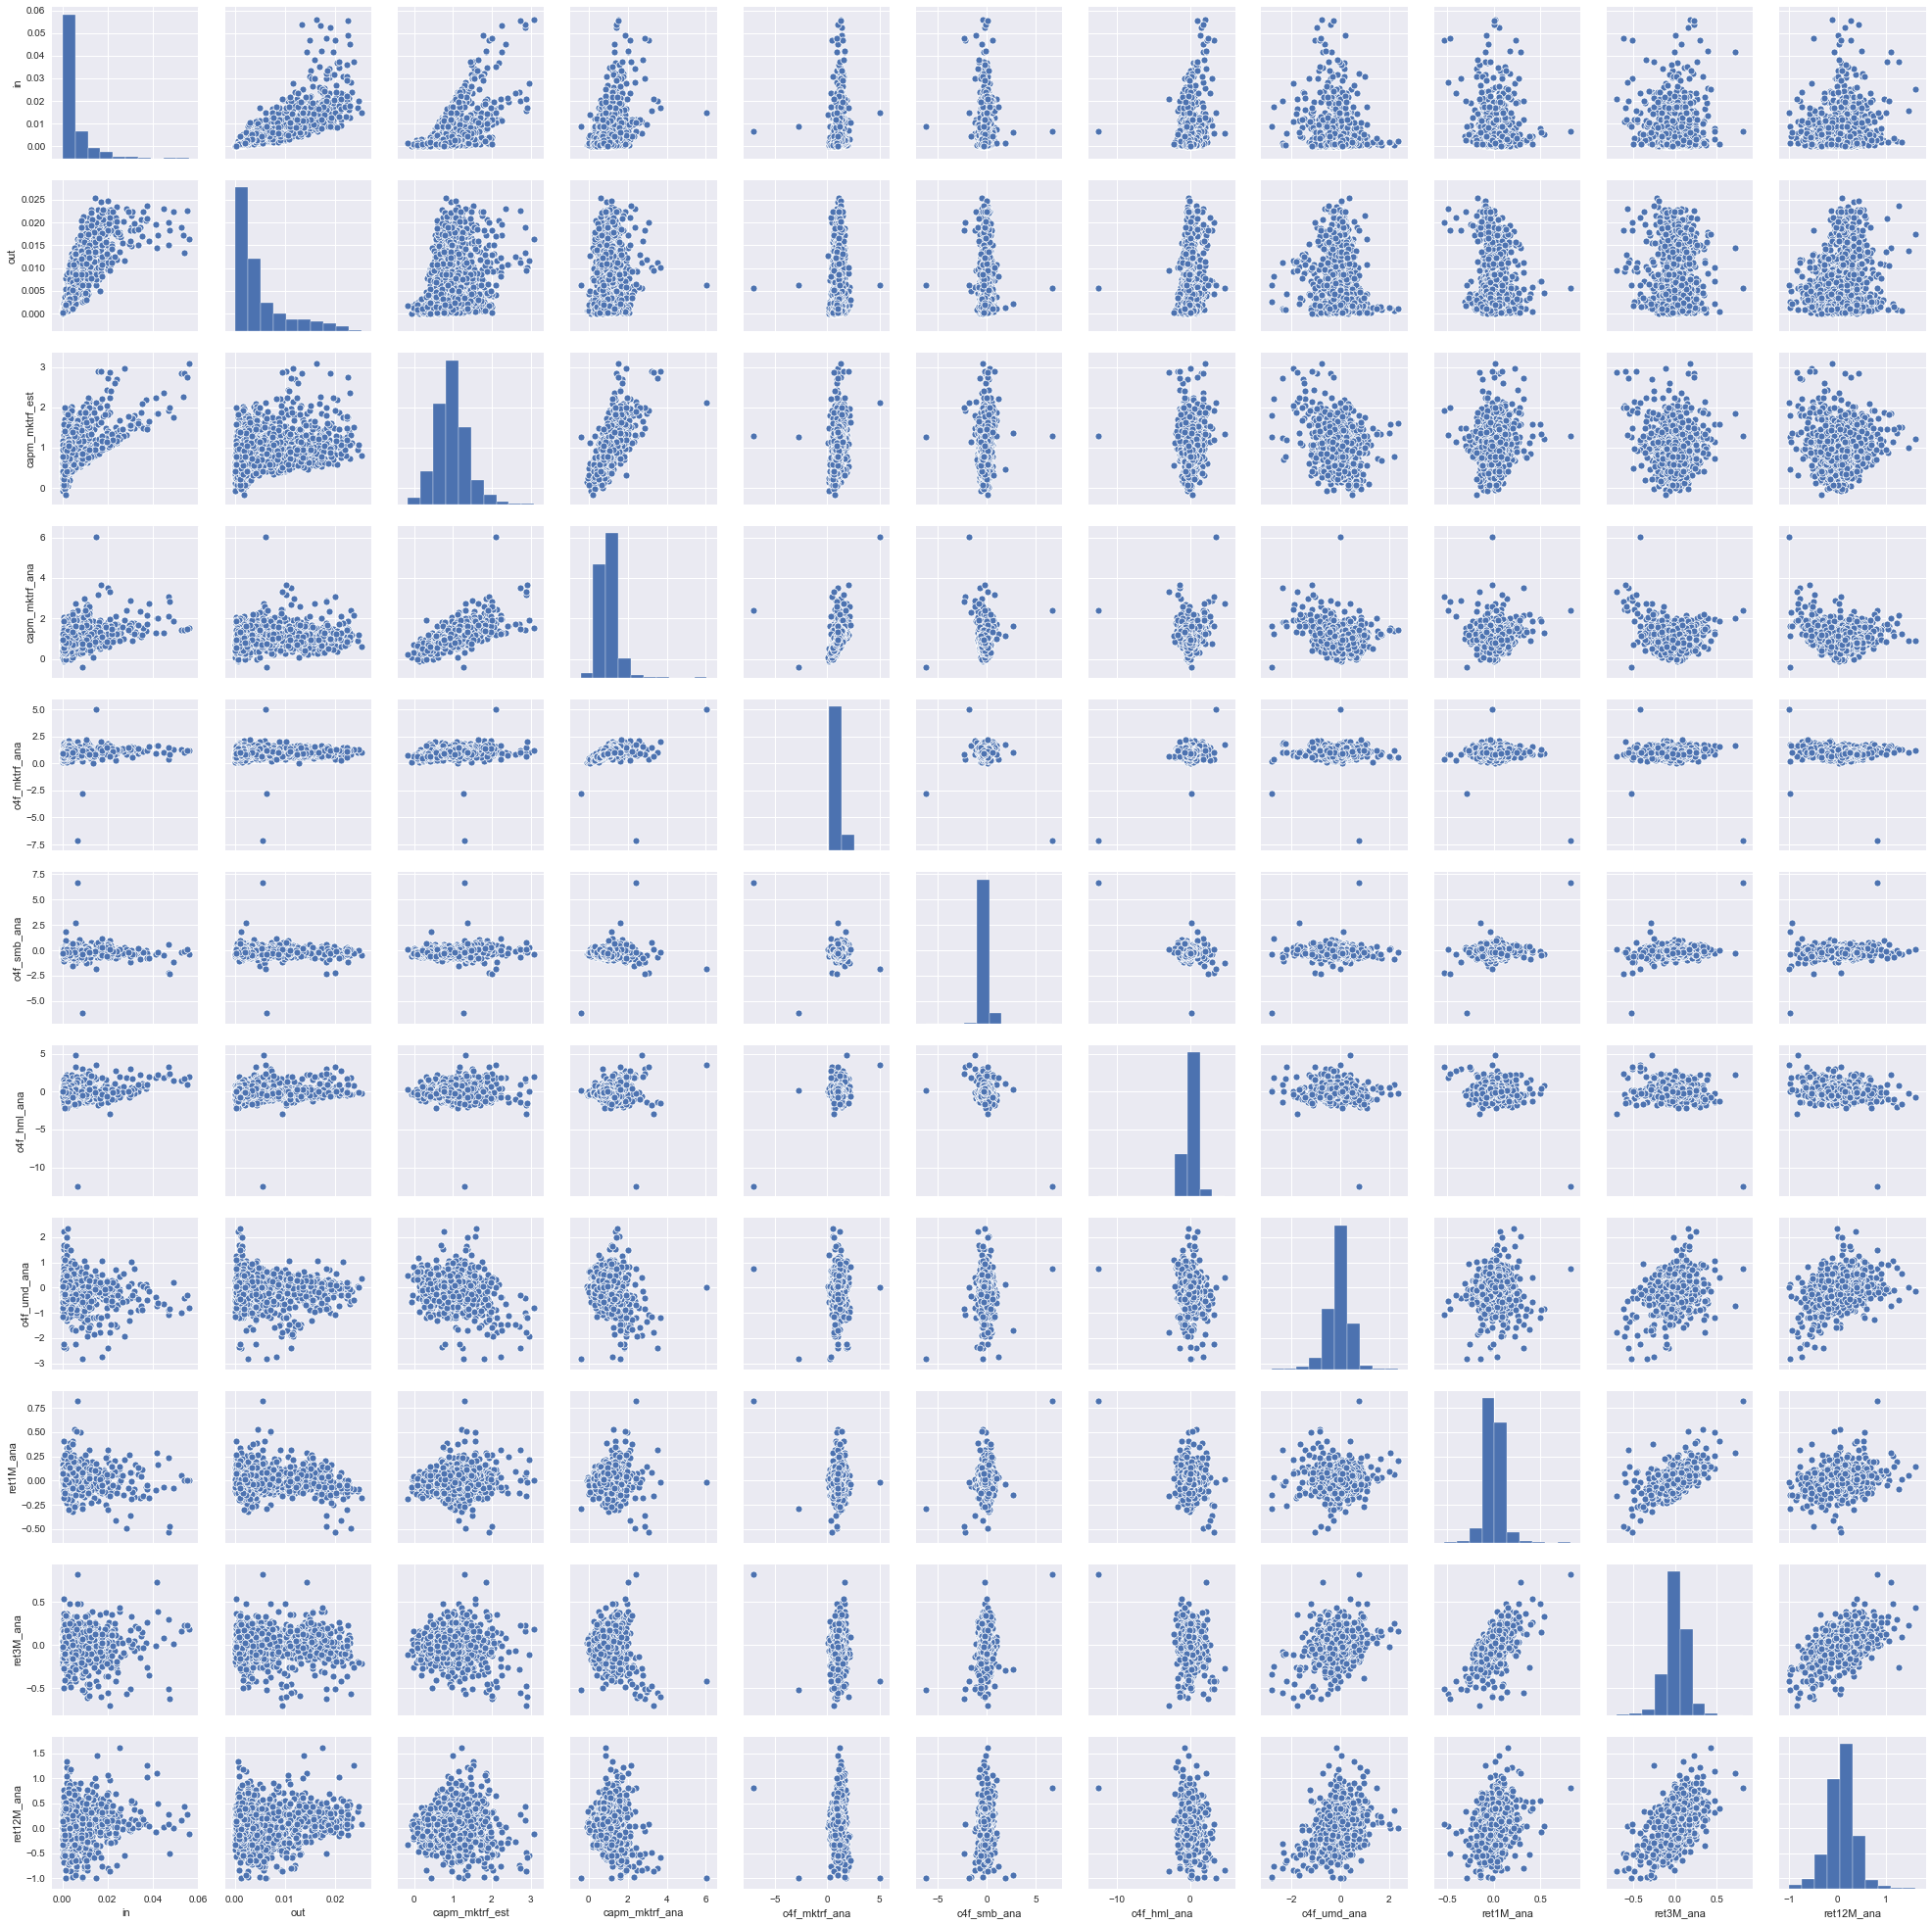

In [14]:
sns.pairplot(df_merged.loc[:,['in','out','capm_mktrf_est','capm_mktrf_ana','c4f_mktrf_ana','c4f_smb_ana','c4f_hml_ana','c4f_umd_ana','ret1M_ana','ret3M_ana','ret12M_ana']])
plt.show()

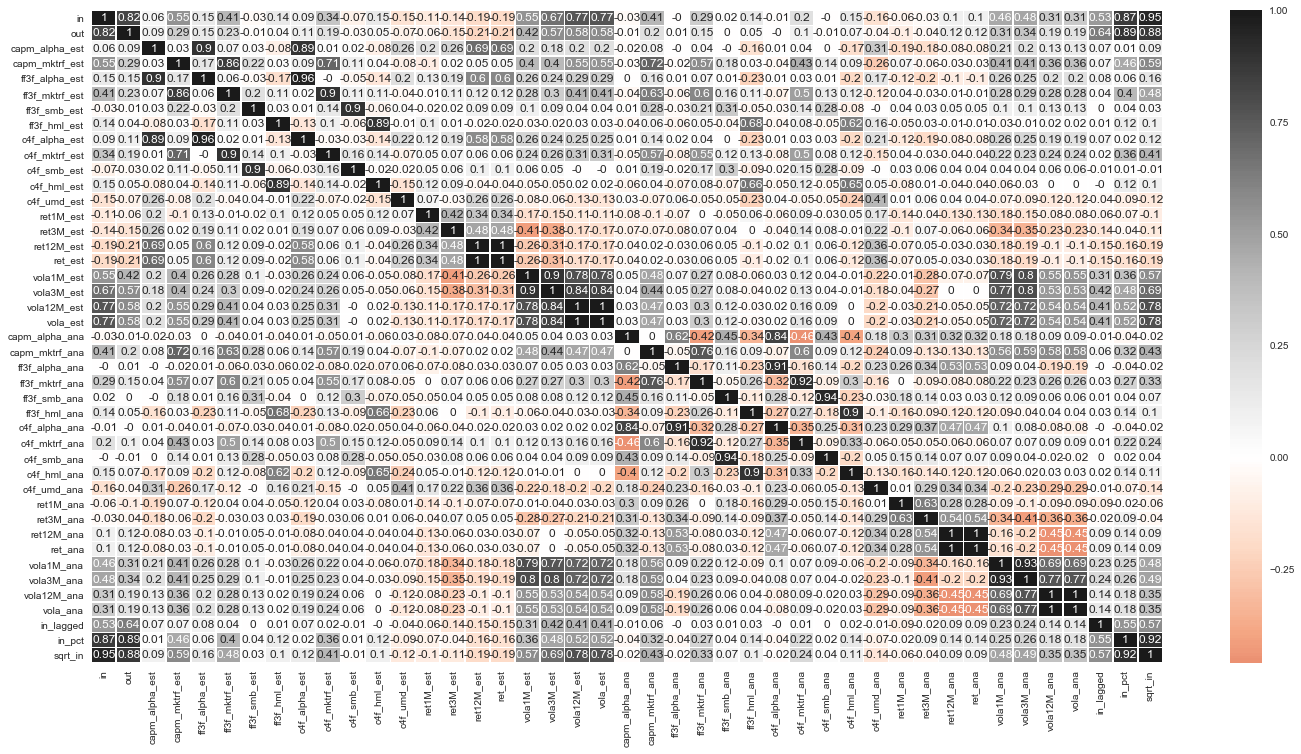

In [15]:
_ = df_merged.plot_corr(figsize=[24,12])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


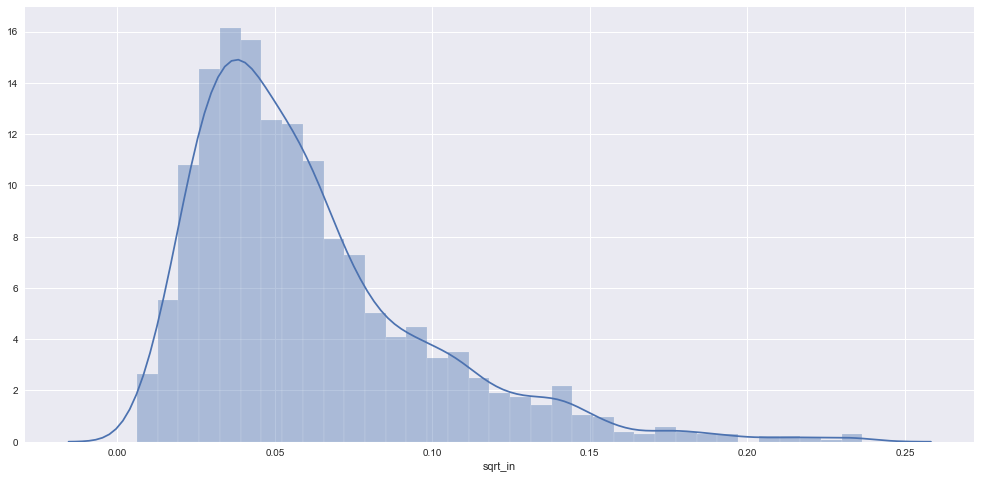

In [16]:
sns.distplot(df_merged['sqrt_in'])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


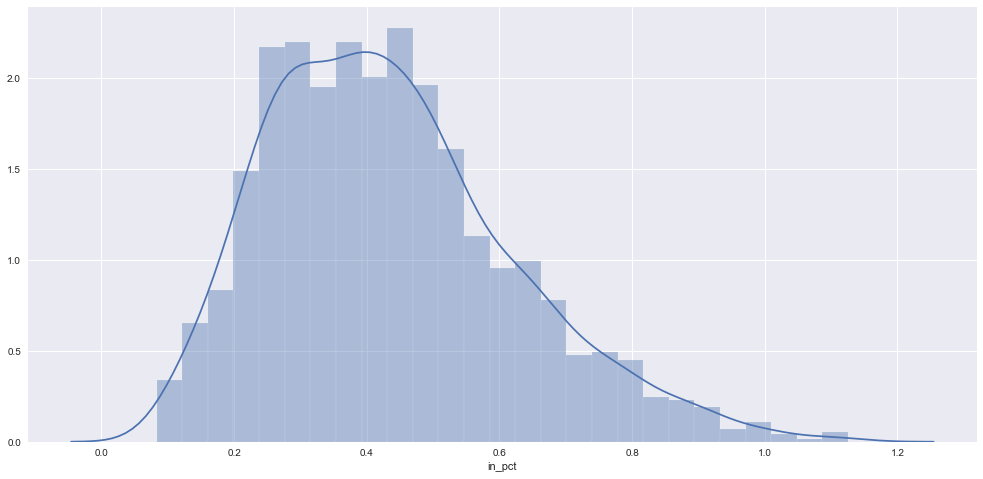

In [17]:
sns.distplot(np.sqrt(df_merged['in_pct']))
plt.show()

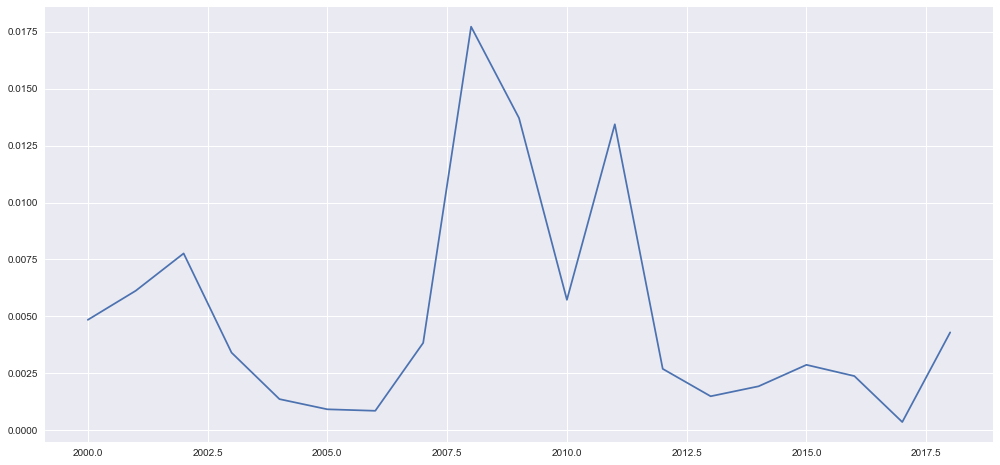

In [18]:
df_merged['in'].groupby(df_merged.index.get_level_values(1)).mean().plot()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


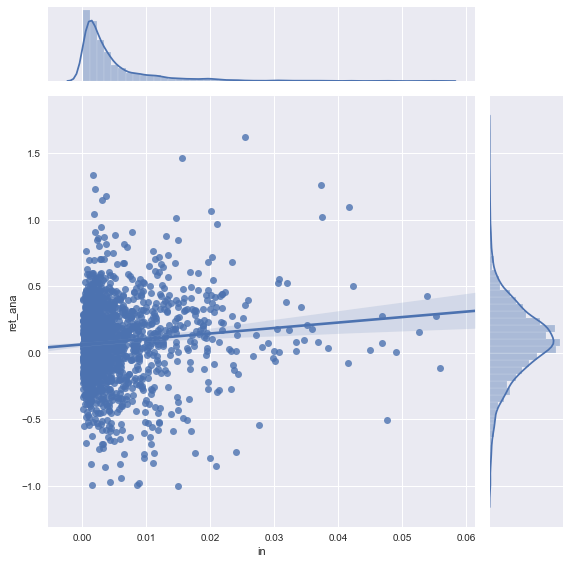

In [19]:
sns.jointplot(x='in', y='ret_ana', data=df_merged, kind='reg', height=8)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


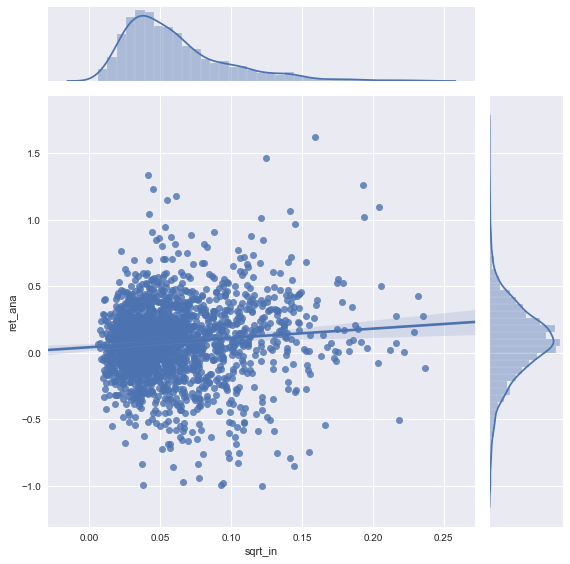

In [20]:
sns.jointplot(x=df_merged['sqrt_in'], y=df_merged['ret_ana'], kind='reg', height=8)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


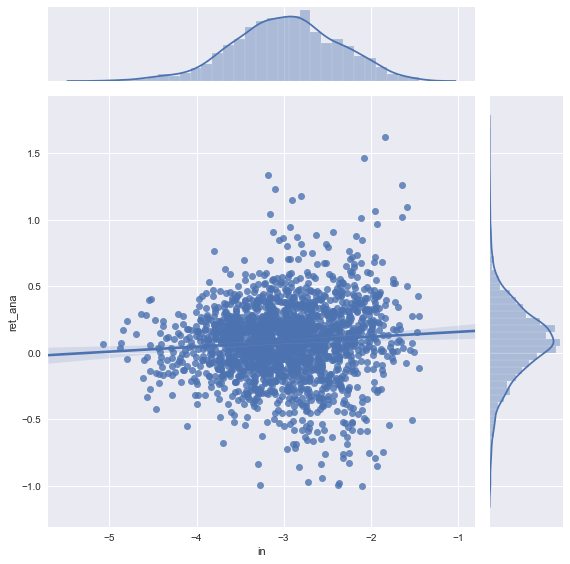

In [23]:
sns.jointplot(x=np.log(np.sqrt(df_merged['in'])), y=df_merged['ret_ana'], kind='reg', height=8)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


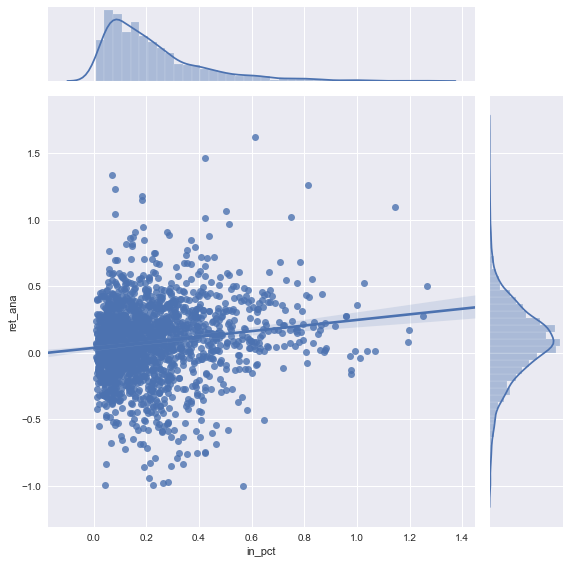

In [41]:
sns.jointplot(x=df_merged['in_pct'], y=df_merged['ret_ana'], kind='reg', height=8)
plt.show()

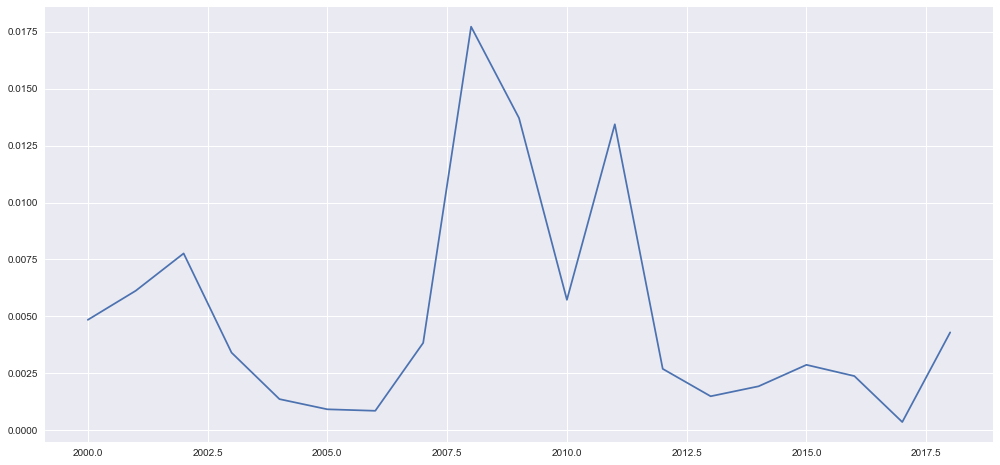

In [46]:
df_merged['in'].groupby(df_merged.index.get_level_values(1)).mean().plot()
plt.show()

## Regressions

In [23]:
def get_var_order(exogs):
    vars_long = []
    vars_short = ['const']
    for reg in exogs:
        if type(reg) is str:
            vars_long += [reg]
        else:
            vars_long += reg
    for var in vars_long:
        if var not in vars_short:
            vars_short += [var]
    return vars_short

In [28]:
exogs = ['in',
        # 'in_pct',
         #'out',
         ['in','capm_mktrf_est','ret_est'],
         ['in','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['ff3f_mktrf_est','ff3f_smb_est','ff3f_hml_est'],
         #['c4f_mktrf_est','c4f_smb_est','c4f_hml_est','c4f_umd_est']
         ]
effects = [[],
           ['time'],
           ['entity'],
           ['time', 'entity']]

add_outputs = ['Time FE', 'Entity FE', 'N', 'R-squared', 'R-squared (inclusive)']

var_order = get_var_order(exogs)#['const','in','capm_mktrf_ana','ff3f_mktrf_ana','ff3f_smb_ana','ff3f_hml_ana','c4f_mktrf_ana','c4f_smb_ana','c4f_hml_ana','c4f_umd_ana']

In [34]:
table_panel_regressions = kf.RegressionTable()
endog = 'ret12M_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
                                        .join_regression(df_merged.fit_panel_regression\
                                        (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0, cov_type='kernel'),\
                                        add_outputs=add_outputs)
table_panel_regressions\
    .change_descriptive_order(add_outputs)\
    .change_variable_order(var_order)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)        (2)        (3)       (4)  \
const                 coeff    0.0628*                                   
                      t-stat  (1.7337)                                   
in                    coeff    4.1096*    -0.0541  6.9637***    3.0241   
                      t-stat  (1.8925)  (-0.0247)   (3.3070)  (1.3906)   
capm_mktrf_est        coeff                                              
                      t-stat                                             
ret_est               coeff                                              
                      t-stat                                             
Time FE                          False       True      False      True   
Entity FE                        False      False       True      True   
N                                 1896       1896       1896      1896   
R-squared                       0.0093     0.0000     0.0260    0.0034   
R-squared (inclusive)           0.0093     0.3761     0.1997    0.4982   

                                    (5)        (6)        (7)         (8)  \
const                 coeff   0.1324***                                     
                      t-stat   (5.1691)                                     
in                    coeff   7.0372***  5.4021***  7.7572***   7.7835***   
                      t-stat   (2.6275)   (2.8006)   (3.1171)    (3.7026)   
capm_mktrf_est        coeff    -0.0872*  -0.0858**    -0.0658  -0.1155***   
                      t-stat  (-1.7734)  (-2.3775)  (-1.3666)   (-2.7110)   
ret_est               coeff      0.0038     0.0130    -0.0443     -0.0239   
                      t-stat   (0.1018)   (0.3795)  (-1.2067)   (-0.8195)   
Time FE                           False       True      False        True   
Entity FE                         False      False       True        True   
N                                  1896       1896       1896        1896   
R-squared                        0.0202     0.0103     0.0324      0.0162   
R-squared (inclusive)            0.0202     0.3825     0.2050      0.5047   

                                    (9)       (10)       (11)        (12)  
const                 coeff   0.1326***                                    
                      t-stat   (5.3102)                                    
in                    coeff    6.9799**  5.2683***  8.4059***   7.9740***  
                      t-stat   (2.3132)   (2.6412)   (2.9855)    (3.8885)  
capm_mktrf_est        coeff    -0.0865*  -0.0843**    -0.0714  -0.1166***  
                      t-stat  (-1.6550)  (-2.1350)  (-1.4087)   (-2.8107)  
ret_est               coeff                                                
                      t-stat                                               
Time FE                           False       True      False        True  
Entity FE                         False      False       True        True  
N                                  1896       1896       1896        1896  
R-squared                        0.0201     0.0101     0.0299      0.0153  
R-squared (inclusive)            0.0201     0.3823     0.2030      0.5042

In [35]:
exogs = ['in_pct',
        # 'in_pct',
         #'out',
         ['in_pct','capm_mktrf_est','ret_est'],
         ['in_pct','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['ff3f_mktrf_est','ff3f_smb_est','ff3f_hml_est'],
         #['c4f_mktrf_est','c4f_smb_est','c4f_hml_est','c4f_umd_est']
         ]
effects = [[],
           ['time'],
           ['entity'],
           ['time', 'entity']]

add_outputs = ['Time FE', 'Entity FE', 'N', 'R-squared', 'R-squared (inclusive)']

var_order = get_var_order(exogs)#['const','in','capm_mktrf_ana','ff3f_mktrf_ana','ff3f_smb_ana','ff3f_hml_ana','c4f_mktrf_ana','c4f_smb_ana','c4f_hml_ana','c4f_umd_ana']

In [39]:
table_panel_regressions = kf.RegressionTable()
endog = 'ret12M_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
                                        .join_regression(df_merged.fit_panel_regression\
                                        (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0, cov_type='kernel'),\
                                        add_outputs=add_outputs)
table_panel_regressions\
    .change_descriptive_order(add_outputs)\
    .change_variable_order(var_order)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)       (2)        (3)       (4)  \
const                 coeff      0.0364                                  
                      t-stat   (0.8644)                                  
in_pct                coeff   0.2103***    0.0085  0.2691***    0.1321   
                      t-stat   (2.8859)  (0.1096)   (2.7495)  (1.2611)   
capm_mktrf_est        coeff                                              
                      t-stat                                             
ret_est               coeff                                              
                      t-stat                                             
Time FE                           False      True      False      True   
Entity FE                         False     False       True      True   
N                                  1896      1896       1896      1896   
R-squared                        0.0193    0.0000     0.0307    0.0028   
R-squared (inclusive)            0.0193    0.3761     0.2035    0.4979   

                                    (5)        (6)        (7)         (8)  \
const                 coeff   0.1011***                                     
                      t-stat   (4.6141)                                     
in_pct                coeff   0.2971***   0.2500**   0.2784**   0.3420***   
                      t-stat   (2.7068)   (2.4386)   (2.4727)    (5.0434)   
capm_mktrf_est        coeff   -0.0868**  -0.0884**    -0.0486  -0.1069***   
                      t-stat  (-2.2550)  (-2.2721)  (-1.1205)   (-2.9326)   
ret_est               coeff      0.0034     0.0103    -0.0483     -0.0314   
                      t-stat   (0.0795)   (0.2935)  (-1.2608)   (-1.0374)   
Time FE                           False       True      False        True   
Entity FE                         False      False       True        True   
N                                  1896       1896       1896        1896   
R-squared                        0.0315     0.0113     0.0359      0.0146   
R-squared (inclusive)            0.0315     0.3831     0.2079      0.5039   

                                    (9)       (10)       (11)        (12)  
const                 coeff   0.1015***                                    
                      t-stat   (4.6603)                                    
in_pct                coeff    0.2958**   0.2475**   0.2984**   0.3432***  
                      t-stat   (2.5727)   (2.2691)   (2.4079)    (5.3530)  
capm_mktrf_est        coeff   -0.0864**  -0.0876**    -0.0518  -0.1061***  
                      t-stat  (-2.1189)  (-2.0960)  (-1.1973)   (-3.1808)  
ret_est               coeff                                                
                      t-stat                                               
Time FE                           False       True      False        True  
Entity FE                         False      False       True        True  
N                                  1896       1896       1896        1896  
R-squared                        0.0315     0.0111     0.0330      0.0130  
R-squared (inclusive)            0.0315     0.3830     0.2054      0.5031

In [57]:
exogs = ['sqrt_in',
        # 'in_pct',
         #'out',
         ['sqrt_in','capm_mktrf_est','ret_est'],
         ['sqrt_in','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['in','capm_mktrf_est'],
         #['ff3f_mktrf_est','ff3f_smb_est','ff3f_hml_est'],
         #['c4f_mktrf_est','c4f_smb_est','c4f_hml_est','c4f_umd_est']
         ]
effects = [[],
           ['time'],
           ['entity'],
           ['time', 'entity']]

add_outputs = ['Time FE', 'Entity FE', 'N', 'R-squared', 'R-squared (inclusive)']

var_order = get_var_order(exogs)#['const','in','capm_mktrf_ana','ff3f_mktrf_ana','ff3f_smb_ana','ff3f_hml_ana','c4f_mktrf_ana','c4f_smb_ana','c4f_hml_ana','c4f_umd_ana']

In [58]:
table_panel_regressions = kf.RegressionTable()
endog = 'ret12M_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
                                        .join_regression(df_merged.fit_panel_regression\
                                        (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0, cov_type='kernel'),\
                                        add_outputs=add_outputs)
table_panel_regressions\
    .change_descriptive_order(add_outputs)\
    .change_variable_order(var_order)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)        (2)       (3)       (4)  \
const                 coeff     0.0411                                  
                      t-stat  (1.0268)                                  
sqrt_in               coeff     0.7004    -0.2048  1.2650**    0.3862   
                      t-stat  (1.4615)  (-0.4000)  (2.5542)  (0.5962)   
capm_mktrf_est        coeff                                             
                      t-stat                                            
ret_est               coeff                                             
                      t-stat                                            
Time FE                          False       True     False      True   
Entity FE                        False      False      True      True   
N                                 1896       1896      1896      1896   
R-squared                       0.0081     0.0004    0.0246    0.0010   
R-squared (inclusive)           0.0081     0.3763    0.1986    0.4970   

                                    (5)         (6)        (7)         (8)  \
const                 coeff   0.0938***                                      
                      t-stat   (4.1916)                                      
sqrt_in               coeff    1.3059**   2.0159***   1.4076**   2.6198***   
                      t-stat   (2.3906)    (2.6721)   (2.4152)    (4.0097)   
capm_mktrf_est        coeff   -0.0923**  -0.1413***    -0.0643  -0.1759***   
                      t-stat  (-2.1936)   (-2.6451)  (-1.3532)   (-3.5160)   
ret_est               coeff      0.0037      0.0110    -0.0444     -0.0283   
                      t-stat   (0.0996)    (0.3091)  (-1.3160)   (-0.9493)   
Time FE                           False        True      False        True   
Entity FE                         False       False       True        True   
N                                  1896        1896       1896        1896   
R-squared                        0.0195      0.0128     0.0308      0.0176   
R-squared (inclusive)            0.0195      0.3840     0.2037      0.5053   

                                    (9)       (10)       (11)        (12)  
const                 coeff   0.0942***                                    
                      t-stat   (4.1418)                                    
sqrt_in               coeff    1.2952**   1.9953**   1.5330**   2.6516***  
                      t-stat   (2.1271)   (2.5372)   (2.3879)    (4.1375)  
capm_mktrf_est        coeff   -0.0916**  -0.1400**    -0.0702  -0.1767***  
                      t-stat  (-1.9652)  (-2.4379)  (-1.4023)   (-3.6916)  
ret_est               coeff                                                
                      t-stat                                               
Time FE                           False       True      False        True  
Entity FE                         False      False       True        True  
N                                  1896       1896       1896        1896  
R-squared                        0.0195     0.0126     0.0284      0.0163  
R-squared (inclusive)            0.0195     0.3839     0.2017      0.5047

In [61]:
table_panel_regressions = kf.RegressionTable()
endog = 'var12M_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
                                        .join_regression(df_merged.fit_panel_regression\
                                        (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0),\
                                        add_outputs=add_outputs)
table_panel_regressions\
    .change_variable_order(var_order)\
    .change_descriptive_order(add_outputs)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)        (2)       (3)       (4)  \
const                 coeff      0.0000                                  
                      t-stat   (0.4543)                                  
sqrt_in               coeff   0.0072***  0.0126***  0.0051**  0.0097**   
                      t-stat   (2.6177)   (2.6882)  (2.3668)  (2.2673)   
capm_mktrf_est        coeff                                              
                      t-stat                                             
ret_est               coeff                                              
                      t-stat                                             
Time FE                           False       True     False      True   
Entity FE                         False      False      True      True   
N                                  1896       1896      1896      1896   
R-squared                        0.0365     0.0520    0.0274    0.0311   
R-squared (inclusive)            0.0365     0.1890    0.5054    0.5997   

                                     (5)        (6)        (7)        (8)  \
const                 coeff     -0.0002*                                    
                      t-stat   (-1.8204)                                    
sqrt_in               coeff       0.0027     0.0002    0.0032*     0.0056   
                      t-stat    (1.1129)   (0.0347)   (1.7431)   (1.1572)   
capm_mktrf_est        coeff     0.0006**   0.0008**    0.0004*     0.0003   
                      t-stat    (2.2648)   (1.9911)   (1.8563)   (1.3723)   
ret_est               coeff   -0.0003***    -0.0002    -0.0002    -0.0001   
                      t-stat   (-2.6908)  (-1.5155)  (-1.3497)  (-0.7409)   
Time FE                            False       True      False       True   
Entity FE                          False      False       True       True   
N                                   1896       1896       1896       1896   
R-squared                         0.0594     0.0652     0.0372     0.0352   
R-squared (inclusive)             0.0594     0.2002     0.5104     0.6014   

                                    (9)      (10)      (11)      (12)  
const                 coeff   -0.0003**                                
                      t-stat  (-2.0472)                                
sqrt_in               coeff      0.0036    0.0006   0.0038*    0.0058  
                      t-stat   (1.4431)  (0.0888)  (1.9269)  (1.1731)  
capm_mktrf_est        coeff    0.0006**   0.0008*   0.0003*    0.0003  
                      t-stat   (2.1477)  (1.8204)  (1.8684)  (1.3263)  
ret_est               coeff                                            
                      t-stat                                           
Time FE                           False      True     False      True  
Entity FE                         False     False      True      True  
N                                  1896      1896      1896      1896  
R-squared                        0.0543    0.0632    0.0335    0.0335  
R-squared (inclusive)            0.0543    0.1985    0.5086    0.6007

In [55]:
exogs = ['in',
         'capm_mktrf_est',
         ['in','out','capm_mktrf_est']]
effects = [[],
           ['time'],
           ['entity'],
           ['time', 'entity']]

add_outputs = ['Time FE', 'Entity FE', 'N', 'R-squared', 'R-squared (inclusive)']

var_order = ['const','in','out','capm_mktrf_est','capm_mktrf_ana']

In [54]:
table_panel_regressions = kf.RegressionTable()
endog = 'capm_mktrf_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
            .join_regression(df_merged.fit_panel_regression\
            (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0),\
            add_outputs=add_outputs)
table_panel_regressions\
    .change_variable_order(var_order)\
    .change_descriptive_order(add_outputs)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)         (2)         (3)         (4)  \
const                 coeff    0.8565***                                       
                      t-stat   (34.9934)                                       
in                    coeff   26.0591***  50.3926***  11.7218***  23.7032***   
                      t-stat    (4.0196)    (4.3435)    (3.7796)    (3.6460)   
capm_mktrf_est        coeff                                                    
                      t-stat                                                   
ret_est               coeff                                                    
                      t-stat                                                   
capm_alpha_est        coeff                                                    
                      t-stat                                                   
Time FE                            False        True       False        True   
Entity FE                          False       False        True        True   
N                                   1896        1896        1896        1896   
R-squared                         0.1676      0.3309      0.0684      0.1224   
R-squared (inclusive)             0.1676      0.3451      0.6325      0.6677   

                                    (5)        (6)        (7)        (8)  \
const                 coeff   0.2552***                                    
                      t-stat   (5.1427)                                    
in                    coeff      0.9925     3.8695     3.7642     9.0410   
                      t-stat   (0.2672)   (0.4844)   (1.0249)   (1.1187)   
capm_mktrf_est        coeff   0.7497***  0.7372***  0.3758***  0.3438***   
                      t-stat  (10.8979)   (8.0848)   (5.6093)   (3.1886)   
ret_est               coeff     -0.0202     0.0153    -0.0299    -0.0117   
                      t-stat  (-0.3238)   (0.2155)  (-0.4017)  (-0.1378)   
capm_alpha_est        coeff                                                
                      t-stat                                               
Time FE                           False       True      False       True   
Entity FE                         False      False       True       True   
N                                  1896       1896       1896       1896   
R-squared                        0.5261     0.5513     0.1691     0.1839   
R-squared (inclusive)            0.5261     0.5608     0.6722     0.6910   

                                     (9)        (10)        (11)        (12)  
const                 coeff    0.8327***                                      
                      t-stat   (39.8087)                                      
in                    coeff   27.5580***  50.5643***  11.1669***  23.2220***  
                      t-stat    (4.0695)    (4.3259)    (3.0623)    (3.5369)  
capm_mktrf_est        coeff                                                   
                      t-stat                                                  
ret_est               coeff       0.1510      0.0600     -0.0358     -0.0963  
                      t-stat    (0.7745)    (0.1589)   (-0.3622)   (-0.4971)  
capm_alpha_est        coeff     -12.6873     10.5228     16.9875     32.9013  
                      t-stat   (-0.2405)    (0.1062)    (0.9269)    (0.7222)  
Time FE                            False        True       False        True  
Entity FE                          False       False        True        True  
N                                   1896        1896        1896        1896  
R-squared                         0.1771      0.3348      0.0698      0.1244  
R-squared (inclusive)             0.1771      0.3488      0.6331      0.6684

In [61]:
table_panel_regressions = kf.RegressionTable()
endog = 'ff3f_hml_ana'

for exog in exogs:
    for fixed_effects in effects:
        table_panel_regressions = table_panel_regressions\
            .join_regression(df_merged.fit_panel_regression\
            (endog=endog, exog=exog, fixed_effects=fixed_effects, lag=0),\
            add_outputs=add_outputs)
table_panel_regressions\
    .change_variable_order(var_order)\
    .change_descriptive_order(add_outputs)

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


(1)       (2)       (3)         (4)  \
const                 coeff     -0.0839                                   
                      t-stat  (-1.6078)                                   
in                    coeff    16.1447*  30.0461*  8.7107**  18.0793***   
                      t-stat   (1.8877)  (1.6656)  (2.3122)    (4.0384)   
out                   coeff                                               
                      t-stat                                              
capm_mktrf_est        coeff                                               
                      t-stat                                              
capm_mktrf_ana        coeff         NaN       NaN       NaN         NaN   
                      t-stat        NaN       NaN       NaN         NaN   
Time FE                           False      True     False        True   
Entity FE                         False     False      True        True   
N                                  1896      1896      1896        1896   
R-squared                        0.0194    0.0354    0.0110      0.0215   
R-squared (inclusive)            0.0194    0.0501    0.5966      0.6295   

                                    (5)       (6)        (7)       (8)  \
const                 coeff     -0.0649                                  
                      t-stat  (-0.2272)                                  
in                    coeff                                              
                      t-stat                                             
out                   coeff                                              
                      t-stat                                             
capm_mktrf_est        coeff      0.0638    0.0649    -0.0099    0.0225   
                      t-stat   (0.2086)  (0.2052)  (-0.0734)  (0.1578)   
capm_mktrf_ana        coeff         NaN       NaN        NaN       NaN   
                      t-stat        NaN       NaN        NaN       NaN   
Time FE                           False      True      False      True   
Entity FE                         False     False       True      True   
N                                  1896      1896       1896      1896   
R-squared                        0.0011    0.0012     0.0000    0.0001   
R-squared (inclusive)            0.0011    0.0164     0.5921    0.6214   

                                      (9)        (10)         (11)        (12)  
const                 coeff        0.1756                                       
                      t-stat     (0.6922)                                       
in                    coeff    49.7146***  58.5444***   42.0031***  39.0440***  
                      t-stat     (4.1225)    (3.9991)     (3.8624)    (3.8222)  
out                   coeff   -39.8051***      4.4887  -40.6025***  -57.4574**  
                      t-stat    (-3.0949)    (0.3907)    (-3.2476)   (-2.4960)  
capm_mktrf_est        coeff       -0.2336     -0.4732     -0.2671*     -0.1476  
                      t-stat    (-0.8238)   (-1.3871)    (-1.8701)   (-0.8335)  
capm_mktrf_ana        coeff           NaN         NaN          NaN         NaN  
                      t-stat          NaN         NaN          NaN         NaN  
Time FE                             False        True        False        True  
Entity FE                           False       False         True        True  
N                                    1896        1896         1896        1896  
R-squared                          0.0429      0.0616       0.0606      0.0678  
R-squared (inclusive)              0.0429      0.0759       0.6168      0.6470